In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
import pandas as pd

2024-07-04 08:17:36.472470: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 08:17:36.501839: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 08:17:36.501862: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 08:17:36.502580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-04 08:17:36.507990: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_csv('./csv/clinical data.csv', sep=';')
df.head()

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,M-Stage,Histopathological grading,Smoking History
0,A0001,M,58.0,65.0,2b,3,1b,G3,1
1,A0002,F,53.0,55.0,2b,1,0,NaN,0
2,A0003,M,60.0,62.0,1c,1,0,G3,0
3,A0004,F,48.0,56.0,1c,3,0,NaN,0
4,A0005,M,70.0,75.0,1b,0,0,G2,1


In [3]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
def dir_to_staging(img_dir, class_list, stage):
    arr = []
    data_dir = os.listdir(img_dir)
    data_dir.sort()
    for pict in data_dir:
        res = df[df["NewPatientID"].str.contains(pict[:5])]
        arr.append(class_list.index(
            str(res[stage+"-Stage"].values[0])[0])
            )
    res = to_categorical(arr, len(class_list))
    np_res = np.array(res)
    return np_res

In [4]:
from tensorflow.keras.preprocessing.image import load_img, random_rotation, random_shear, random_shift
import numpy as np
def img_loader(path, processed = False):
    arr = []
    img_list = os.listdir(path)
    img_list.sort()
    for pict in img_list:
        print('/'.join([path, pict]))
        img = load_img(
            path='/'.join([path, pict]), 
            color_mode='rgb', 
            target_size = (224, 224))
        if(processed):
            img = random_rotation(img, 20)
            img = random_shear(img, 0.25)
            img = random_shift(img, 0.25, 0.25)
        arr.append(img)
    res = np.array(arr)
    return res

In [5]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def conf_matrix(x_test, y_test, model):
    y_true = []
    y_pred = []
    res = model.predict(x_test, verbose=0)
    for i in range(len(x_test)):
        y_true.append(np.argmax(y_test[i]))
        y_pred.append(np.argmax(res[i]))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [6]:
# label staging
T = ["1", "2", "3", "4"]
N = ["0","1", "2", "3"]
M = ["0","1", "2"]

In [7]:
CHANNELS = 3

BATCH_SIZE = 32

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TESTING = 1

In [8]:
src_path_train_tnm = "./Data_pet_CT_TNM/train/img"
src_path_valid_tnm = "./Data_pet_CT_TNM/valid/img"
src_path_test_tnm = "./Data_pet_CT_TNM/test/img"


X_train = img_loader(src_path_train_tnm)
X_valid = img_loader(src_path_valid_tnm)
X_test = img_loader(src_path_test_tnm)

./Data_pet_CT_TNM/train/img/A0001-1-13.png
./Data_pet_CT_TNM/train/img/A0001-1-14.png
./Data_pet_CT_TNM/train/img/A0001-1-15.png
./Data_pet_CT_TNM/train/img/A0001-1-16.png
./Data_pet_CT_TNM/train/img/A0001-1-17.png
./Data_pet_CT_TNM/train/img/A0001-1-18.png
./Data_pet_CT_TNM/train/img/A0001-1-19.png
./Data_pet_CT_TNM/train/img/A0001-1-20.png
./Data_pet_CT_TNM/train/img/A0002-1-09.png
./Data_pet_CT_TNM/train/img/A0002-1-10.png
./Data_pet_CT_TNM/train/img/A0002-1-11.png
./Data_pet_CT_TNM/train/img/A0002-1-12.png
./Data_pet_CT_TNM/train/img/A0002-1-13.png
./Data_pet_CT_TNM/train/img/A0002-1-14.png
./Data_pet_CT_TNM/train/img/A0002-1-15.png
./Data_pet_CT_TNM/train/img/A0003-1-12.png
./Data_pet_CT_TNM/train/img/A0003-1-13.png
./Data_pet_CT_TNM/train/img/A0003-1-14.png
./Data_pet_CT_TNM/train/img/A0004-1-07.png
./Data_pet_CT_TNM/train/img/A0004-1-08.png
./Data_pet_CT_TNM/train/img/A0004-1-09.png
./Data_pet_CT_TNM/train/img/A0004-1-10.png
./Data_pet_CT_TNM/train/img/A0005-1-11.png
./Data_pet_

## T staging

In [9]:
T_train = dir_to_staging(src_path_train_tnm, T, "T")
T_valid = dir_to_staging(src_path_valid_tnm, T, "T")
T_test = dir_to_staging(src_path_test_tnm, T, "T")

In [43]:
model = Sequential()

# base model
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.layers[0].trainable = False

model.add(Flatten())
model.add(BatchNormalization()
# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dropout(0.5))
model.add(Dense(len(T), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 23858692 (91.01 MB)
Trainable params: 266884 (1.02 MB)
Non-trainable params: 23591808 (90.00 MB)
___________

In [44]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [46]:
fit_history = model.fit(
        x=X_train, 
        y=T_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, T_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
)

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 1.3501 - accuracy: 0.5763

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 6s 148ms/step - loss: 1.3529 - accuracy: 0.5764 - val_loss: 0.8169 - val_accuracy: 0.6862
Epoch 2/50
26/26 [==============================] - 3s 131ms/step - loss: 0.5879 - accuracy: 0.7943 - val_loss: 0.6929 - val_accuracy: 0.7181
Epoch 3/50
26/26 [==============================] - 3s 127ms/step - loss: 0.3489 - accuracy: 0.8744 - val_loss: 0.5290 - val_accuracy: 0.7553
Epoch 4/50
26/26 [==============================] - 3s 133ms/step - loss: 0.2388 - accuracy: 0.9039 - val_loss: 0.4288 - val_accuracy: 0.8245
Epoch 5/50
26/26 [==============================] - 3s 126ms/step - loss: 0.1704 - accuracy: 0.9446 - val_loss: 0.2753 - val_accuracy: 0.8989
Epoch 6/50
26/26 [==============================] - 3s 134ms/step - loss: 0.1090 - accuracy: 0.9680 - val_loss: 0.2251 - val_accuracy: 0.9149
Epoch 7/50
26/26 [==============================] - 10s 410ms/step - loss: 0.1008 - accuracy: 0.9618 - val_loss: 0.1990 - val_accuracy: 0.9255
Epoch 8/50
26/26

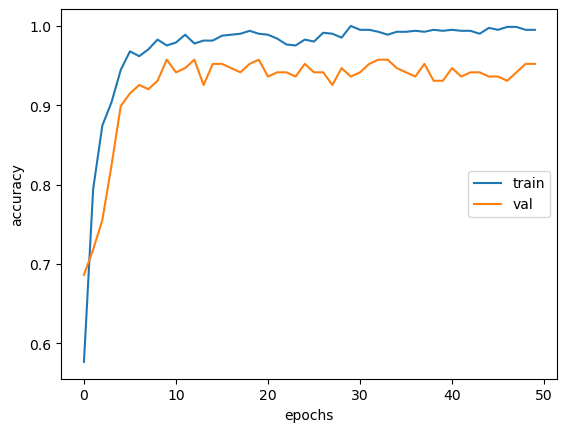

In [47]:
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

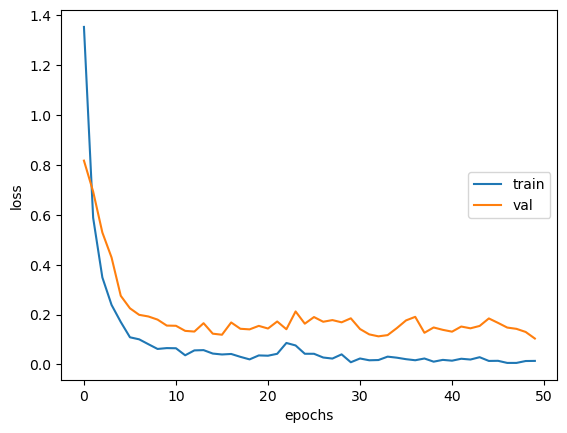

In [48]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [49]:
model.evaluate(x=X_test, y=T_test, batch_size=1)

92/92 [==============================] - 2s 16ms/step - loss: 0.1715 - accuracy: 0.9674


[0.1715477705001831, 0.967391312122345]

9/9 [==============================] - 1s 32ms/step
T stage prediction


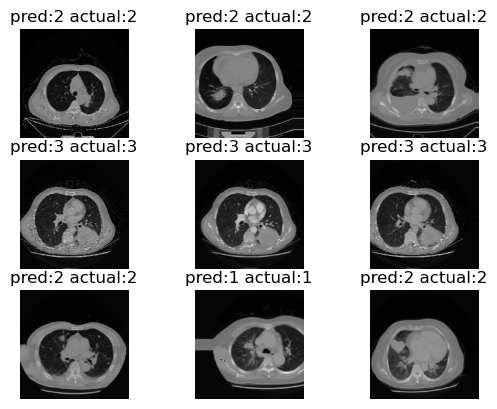

In [50]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("T stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+T[np.argmax(res[i])]+" actual:"+ T[np.argmax(T_test[i])])
    plt.axis('off')
plt.show()

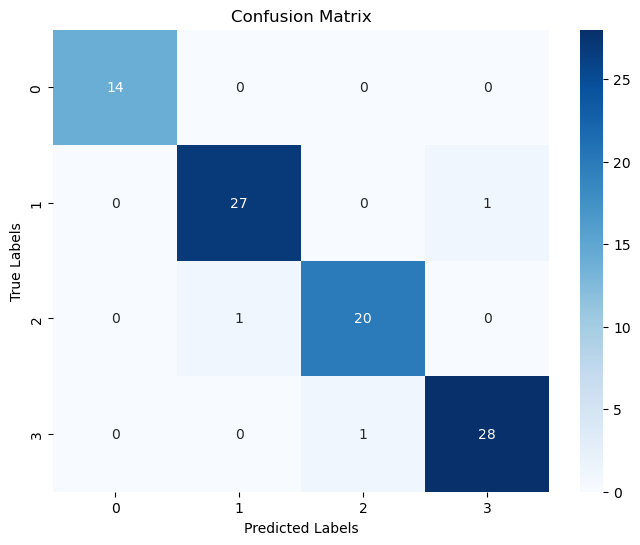

In [51]:
conf_matrix(X_test, T_test, model)

In [ ]:
model.save('./models/TNM/model-t.h5')

## N Staging

In [20]:
N_train = dir_to_staging(src_path_train_tnm, N, "N")
N_valid = dir_to_staging(src_path_valid_tnm, N, "N")
N_test = dir_to_staging(src_path_test_tnm, N, "N")

In [52]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dropout(0.5))
model.add(Dense(len(N), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [53]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_5 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 4)                 516       
                                                      

In [54]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [56]:
fit_history = model.fit(
        x=X_train, 
        y=N_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, N_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
)

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 1.3486 - accuracy: 0.5713

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 6s 147ms/step - loss: 1.3359 - accuracy: 0.5727 - val_loss: 0.8673 - val_accuracy: 0.5638
Epoch 2/50
26/26 [==============================] - 3s 123ms/step - loss: 0.4595 - accuracy: 0.8264 - val_loss: 0.5709 - val_accuracy: 0.7553
Epoch 3/50
26/26 [==============================] - 3s 126ms/step - loss: 0.3111 - accuracy: 0.8645 - val_loss: 0.3917 - val_accuracy: 0.8617
Epoch 4/50
26/26 [==============================] - 3s 128ms/step - loss: 0.1637 - accuracy: 0.9483 - val_loss: 0.3315 - val_accuracy: 0.8936
Epoch 5/50
26/26 [==============================] - 3s 122ms/step - loss: 0.1375 - accuracy: 0.9483 - val_loss: 0.2396 - val_accuracy: 0.9202
Epoch 6/50
26/26 [==============================] - 8s 298ms/step - loss: 0.0860 - accuracy: 0.9741 - val_loss: 0.1917 - val_accuracy: 0.9309
Epoch 7/50
26/26 [==============================] - 12s 481ms/step - loss: 0.0824 - accuracy: 0.9680 - val_loss: 0.1443 - val_accuracy: 0.9468
Epoch 8/50
26/26

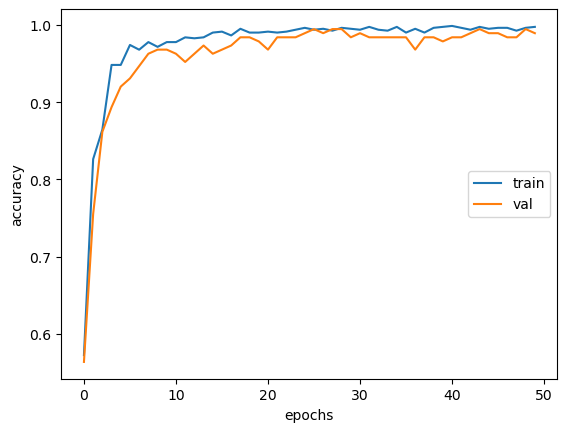

In [57]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

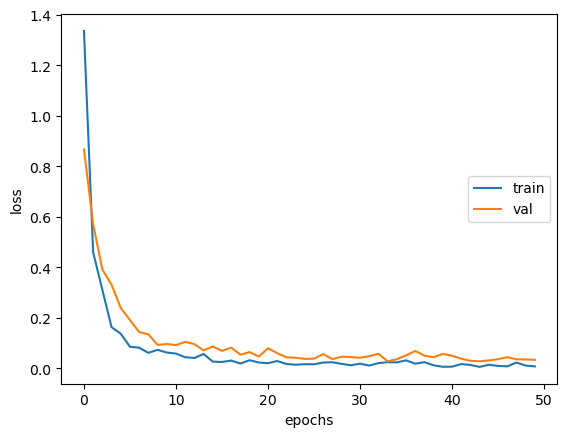

In [58]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [59]:
model.evaluate(x=X_test, y=N_test, batch_size=1)

92/92 [==============================] - 2s 16ms/step - loss: 0.1377 - accuracy: 0.9674


[0.13765472173690796, 0.967391312122345]

9/9 [==============================] - 1s 12ms/step
N stage prediction


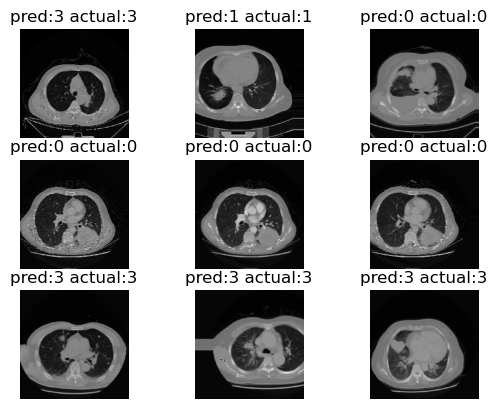

In [60]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("N stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+N[np.argmax(res[i])]+" actual:"+ N[np.argmax(N_test[i])])
    plt.axis('off')
plt.show()

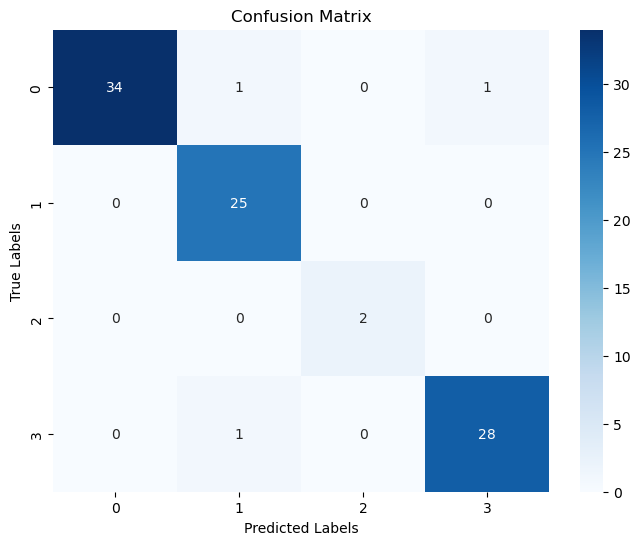

In [61]:
conf_matrix(X_test, N_test, model)

In [ ]:
model.save('./models/TNM/model-n.h5')

## M staging

In [32]:
M_train = dir_to_staging(src_path_train_tnm, M, "M")
M_valid = dir_to_staging(src_path_valid_tnm, M, "M")
M_test = dir_to_staging(src_path_test_tnm, M, "M")

In [72]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
model.add(Dropout(0.5))
model.add(Dense(len(M), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [63]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_6 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 128)               262272    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 3)                 387       
                                                      

In [74]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [75]:
fit_history = model.fit(
        x=X_train, 
        y=M_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, M_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
)

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 1.0098 - accuracy: 0.6300

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 5s 147ms/step - loss: 1.0022 - accuracy: 0.6330 - val_loss: 0.4549 - val_accuracy: 0.7819
Epoch 2/50
26/26 [==============================] - 3s 123ms/step - loss: 0.3714 - accuracy: 0.8534 - val_loss: 0.3854 - val_accuracy: 0.8351
Epoch 3/50
26/26 [==============================] - 3s 123ms/step - loss: 0.2786 - accuracy: 0.9002 - val_loss: 0.2914 - val_accuracy: 0.8883
Epoch 4/50
26/26 [==============================] - 3s 124ms/step - loss: 0.2148 - accuracy: 0.9187 - val_loss: 0.2046 - val_accuracy: 0.9255
Epoch 5/50
26/26 [==============================] - 3s 122ms/step - loss: 0.1309 - accuracy: 0.9507 - val_loss: 0.1538 - val_accuracy: 0.9415
Epoch 6/50
26/26 [==============================] - 3s 122ms/step - loss: 0.1234 - accuracy: 0.9594 - val_loss: 0.1478 - val_accuracy: 0.9468
Epoch 7/50
26/26 [==============================] - 3s 123ms/step - loss: 0.1277 - accuracy: 0.9470 - val_loss: 0.1327 - val_accuracy: 0.9574
Epoch 8/50
26/26 

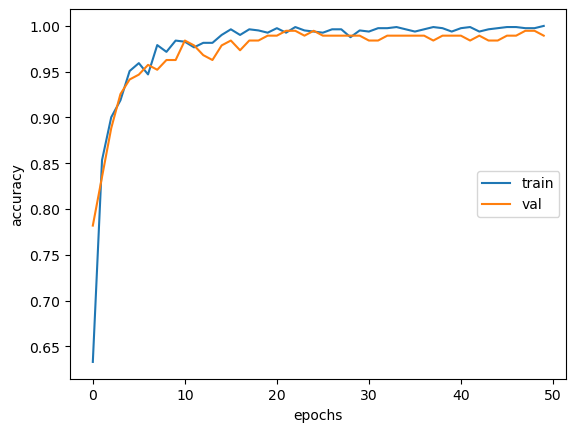

In [76]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

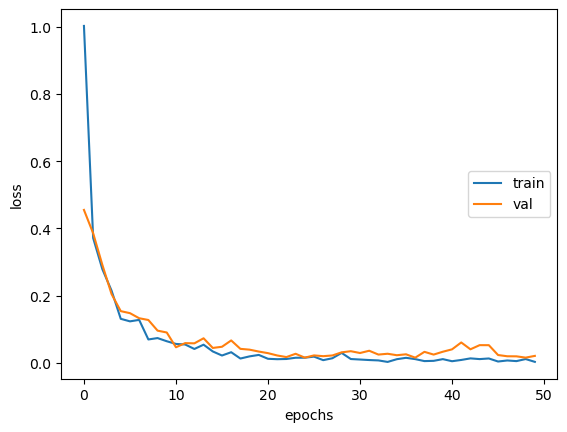

In [77]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [78]:
model.evaluate(x=X_test, y=M_test, batch_size=1)

92/92 [==============================] - 2s 18ms/step - loss: 0.2890 - accuracy: 0.9565


[0.28904101252555847, 0.95652174949646]

9/9 [==============================] - 1s 11ms/step
M stage prediction


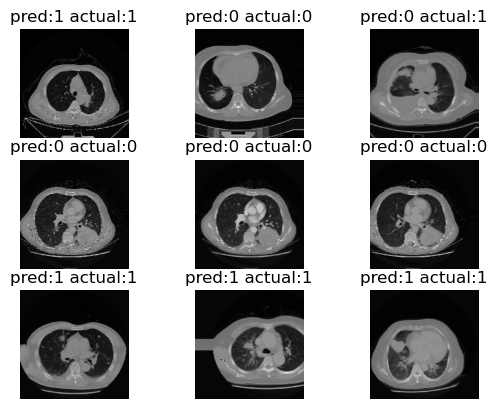

In [79]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("M stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+M[np.argmax(res[i])]+" actual:"+ M[np.argmax(M_test[i])])
    plt.axis('off')
plt.show()

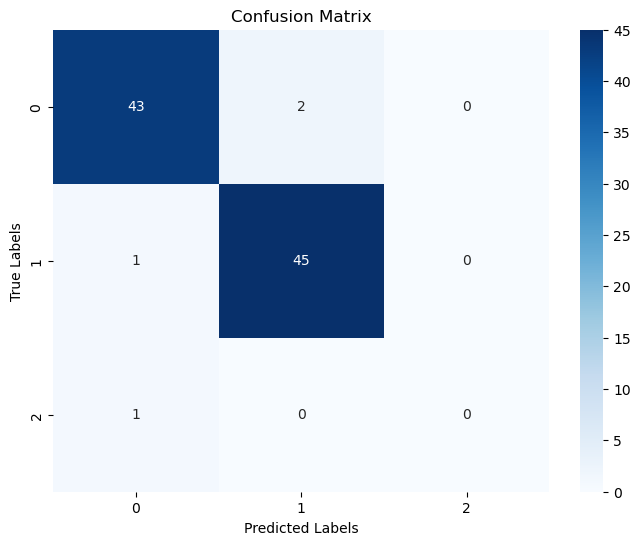

In [80]:
conf_matrix(X_test, M_test, model)

In [ ]:
model.save('./models/TNM/model-m.h5')